/kaggle/input/north-oc-housing-data/north_county_oc - Sheet1.csv
                                      id                         address  \
0   901c820a-e3d0-4af0-8c72-c0fefd4aa318         12688 Chapman Ave #3313   
1   efb200fb-efea-4750-9148-ad388e4b5faa               237 California Ct   
2   71f45354-3fc9-41ce-a09d-9904d547f604       2550 San Gabriel Way #301   
3   e4b150e9-6cd2-46c1-ab41-7f91610bc2f2  23412 Pacific Park Dr Unit 12C   
4   beee20d4-f2f3-408b-95c3-6b8d20ce4661         12688 Chapman Ave #3102   
..                                   ...                             ...   
95  e82eb382-0fd8-4db4-b5b2-66ace9797631                2434 Villena Way   
96  93b2ac27-f735-4b1a-90be-2a71b0348371                  1137 Davis Way   
97  1b76a243-82b8-4ca5-af08-9eb5ce5cd535              924 La Paz Rd # 60   
98  54bce97e-decf-4c20-991d-f7c69c3bfe16         212 S Kraemer Blvd 2111   
99  e5e08e4b-33a3-4bfd-9f8c-9897a3aaf3bc        212 S Kraemer Blvd #1604   

             city stat

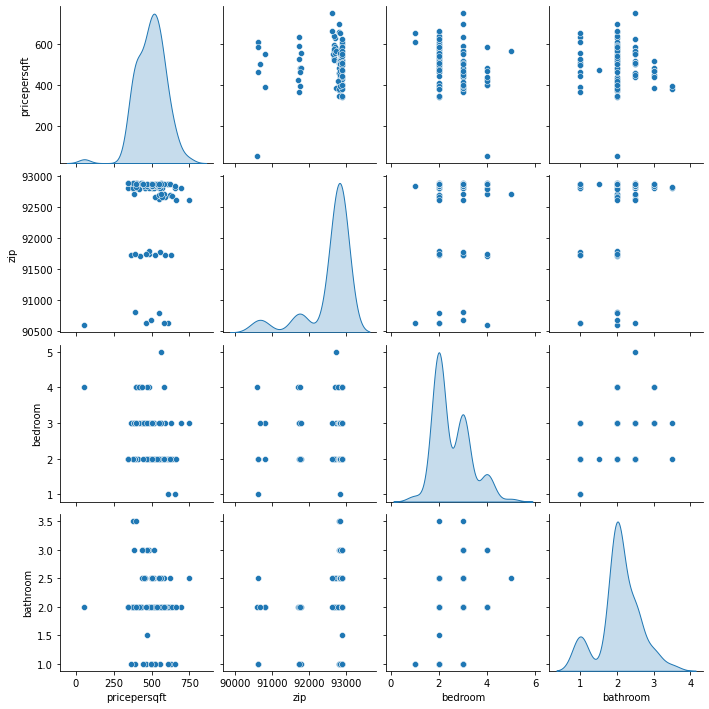

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting library 
import seaborn as sns # data visualization library 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# rename_cols
# parameter: c - columns 
# replaces the column names with the prefix history-
# and adds the appropriate dates to the history 
def rename_cols(c): 
    if c.startswith("history-"):
        return re.sub(r'([0-9]{2})([0-9]{4})', r'\1/01/\2', c.replace("history-", ""))
    
    return c

df = pd.read_csv('/kaggle/input/north-oc-housing-data/north_county_oc - Sheet1.csv')
#making a copy of the dataframe
# Dropping the rows with the value of n/a for the address
data = df.dropna(axis=0, how='all', thresh=None, subset=['address'], inplace=False).copy()
# Rename the columns using the function rename_cols
data.rename(columns=lambda c: rename_cols(c), inplace=True)

##checking for all the null values
data.isnull().sum()

##summary statistics of quantitative variables
data.describe()

##looking at horsepower box plot
# sns.boxplot(x=data['points'])

## adding a price column
## this combines the following columns 
## currentestimate is first since it assumes that 
## the property has not been sold. Sales price is for a 
## recently sold property. Last is the asking price since
## the property is on the market
data['price'] = data['currentestimate'].combine_first(data["saleprice"]).combine_first(data["askingprice"])

# sns.boxplot(x=data['price'])
data['pricepersqft'] = data['price']/data['squareft']

#sns.boxplot(x=data['pricepersqft'])

##pairplots to get an intuition of potential correlations

sns.pairplot(data[["pricepersqft", "zip", "bedroom", "bathroom", "type"]], diag_kind="kde")
print(data)